## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

# rentals_df = pd.read_csv("/home/tahar/project/Maven/Data Science in Python Regression/DataScienceinPythonRegression-230823-154628/Course Materials/Data/sf_clean.csv") 
rentals_df = pd.read_csv("Data/sf_clean.csv")
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [17]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA


## Exploring Target : price

<Axes: ylabel='Frequency'>

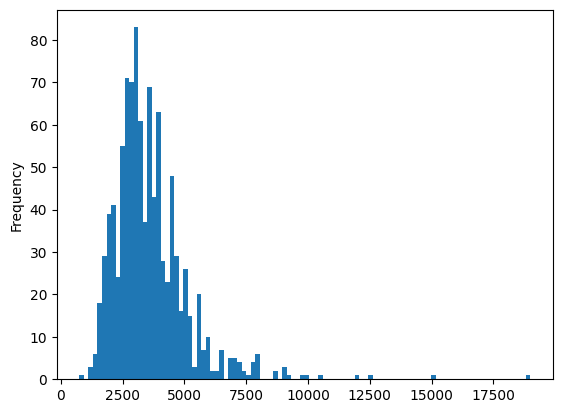

In [43]:
rentals_df.price.plot.hist(bins=100)

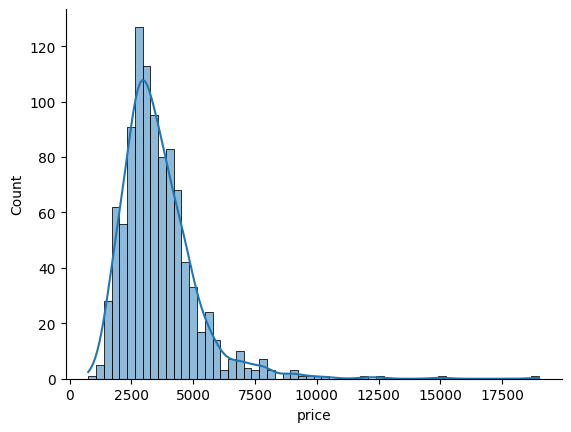

In [54]:
import seaborn as sns
sns.histplot(rentals_df.price, kde=True)
sns.despine()

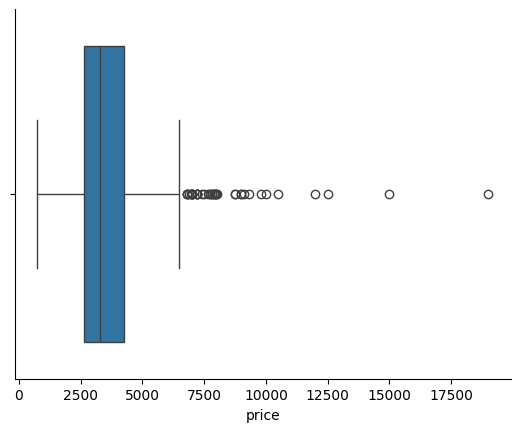

In [53]:
sns.boxplot(x = rentals_df.price)
sns.despine()

## Exploring Features:  

In [55]:
rentals_df["laundry"].value_counts()

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64

<Axes: xlabel='laundry'>

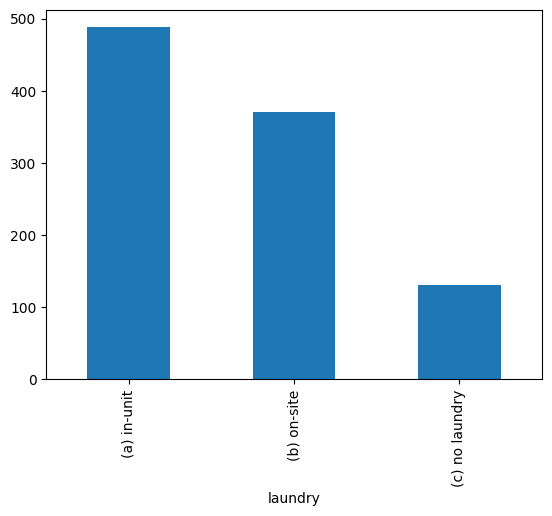

In [59]:
rentals_df["laundry"].value_counts().plot.bar()

In [60]:
rentals_df["pets"].value_counts()

pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64

<Axes: xlabel='pets'>

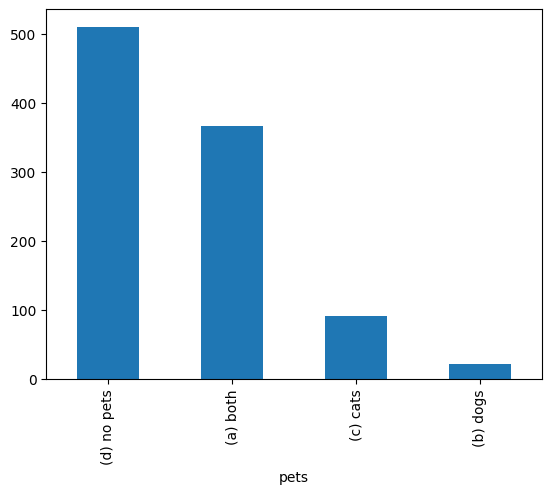

In [61]:
rentals_df["pets"].value_counts().plot.bar()

In [62]:
rentals_df["housing_type"].value_counts()

housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64

<Axes: xlabel='housing_type'>

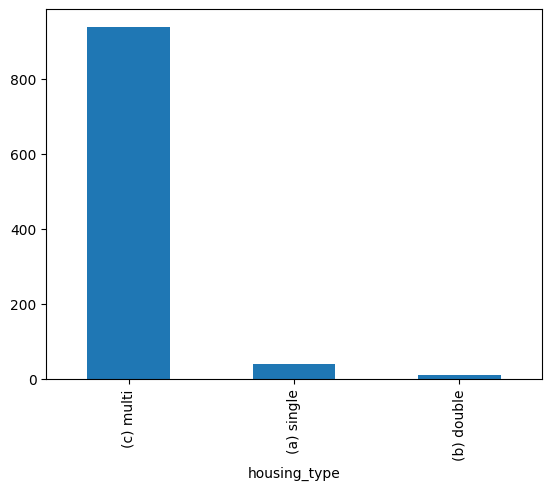

In [63]:
rentals_df["housing_type"].value_counts().plot.bar()

In [64]:
rentals_df["parking"].value_counts()

parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64

<Axes: xlabel='housing_type'>

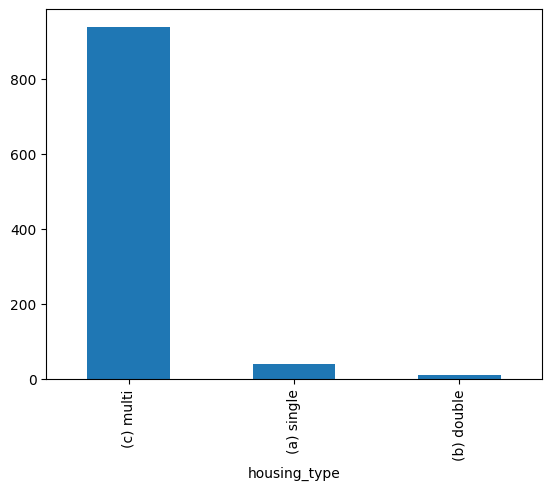

In [66]:
rentals_df["housing_type"].value_counts().plot.bar()

## Correlation

In [67]:
rentals_df.corr(numeric_only=True)

,price,sqft,beds,bath,hood_district
price,1.000000,0.835834,0.673328,0.691190,0.013010
sqft,0.835834,1.000000,0.765070,0.720929,-0.038425
beds,0.673328,0.765070,1.000000,0.629331,-0.109195
bath,0.691190,0.720929,0.629331,1.000000,0.022967
hood_district,0.013010,-0.038425,-0.109195,0.022967,1.000000


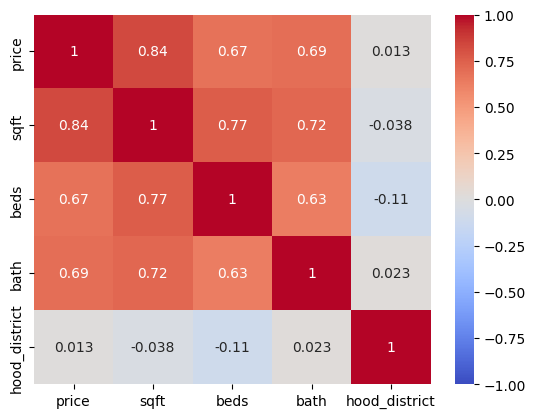

In [73]:
sns.heatmap(rentals_df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm");

## Feature Target Ralationship

<Axes: xlabel='sqft', ylabel='price'>

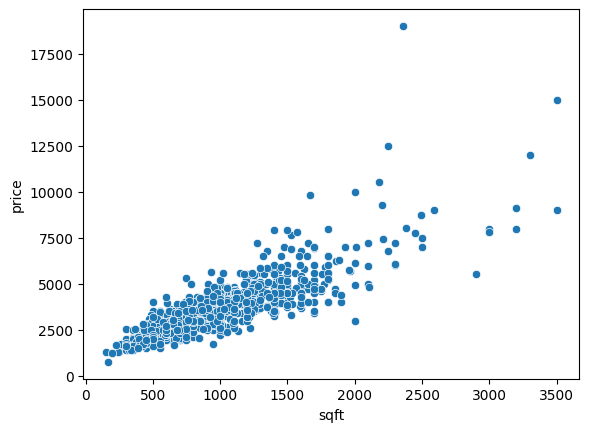

In [74]:
sns.scatterplot(rentals_df, x="sqft", y="price")

<Axes: xlabel='beds', ylabel='price'>

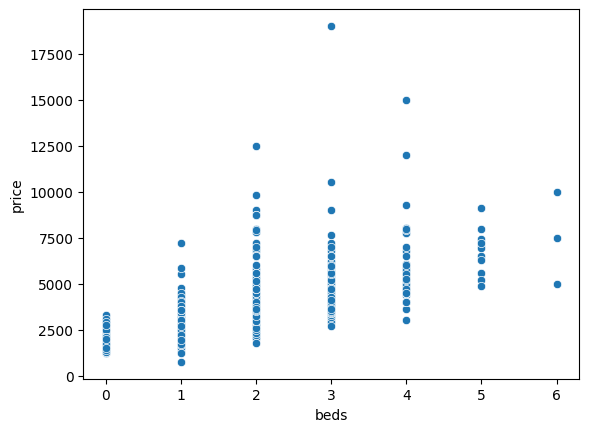

In [75]:
sns.scatterplot(rentals_df, x="beds", y="price")

<Axes: xlabel='bath', ylabel='price'>

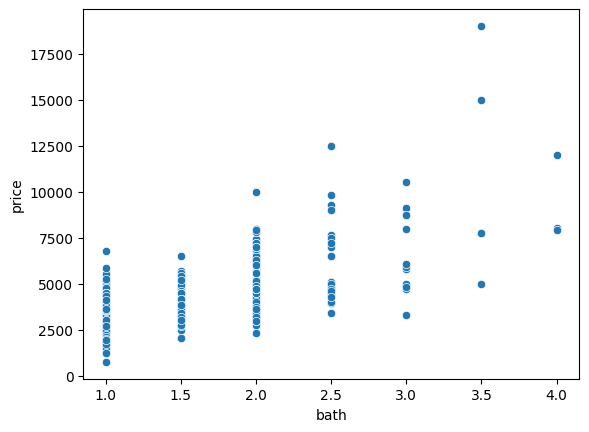

In [76]:
sns.scatterplot(rentals_df, x="bath", y="price")

<Axes: xlabel='hood_district', ylabel='price'>

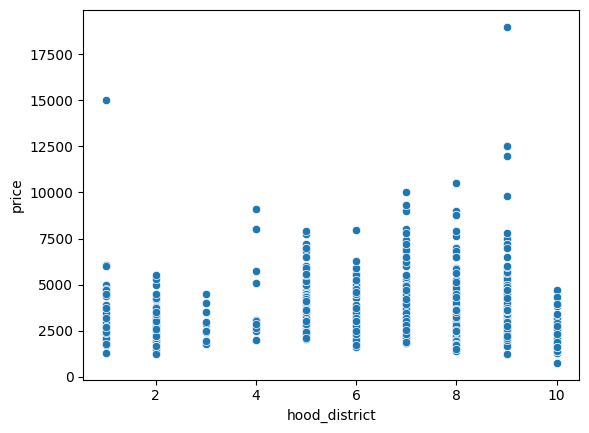

In [78]:
sns.scatterplot(rentals_df, x="hood_district", y="price")

### PRO TIP: PAIRPLOTS
* Use sns.pairplot() to create a pairplot that shows all the scatterplots and 
histograms that can be made using the numeric variables in a DataFrame 

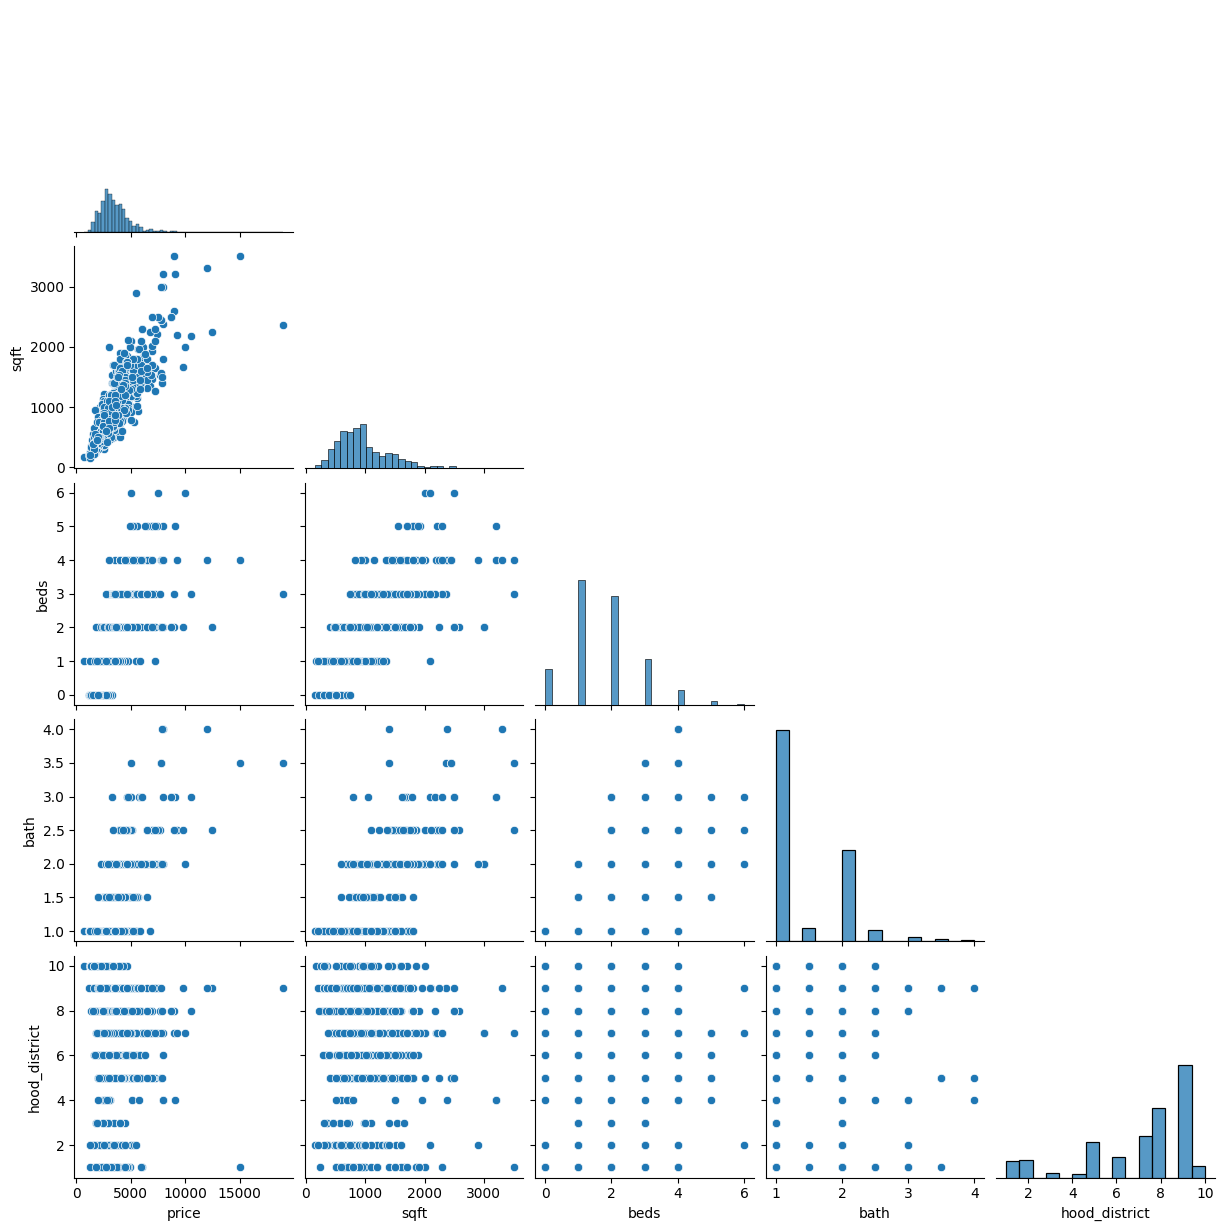

In [81]:
sns.pairplot(rentals_df, corner=True);

### PRO TIP: LMPLOTS
Use sns.lmplot() to create a scatterplot with a fitted regression line 
 * This is commonly used to explore the impact of other variables on a linear relationship
 * sns.lmplot(df, x=“feature”, y=“target”, hue=“categorical feature”

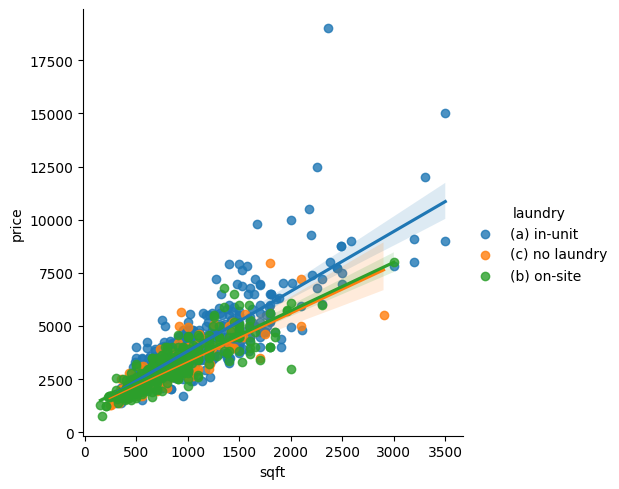

In [83]:
# Categorical Feature : (laundry,	pets,	housing_type,	parking,	hood_district)
sns.lmplot(rentals_df, x="sqft", y="price", hue="laundry")

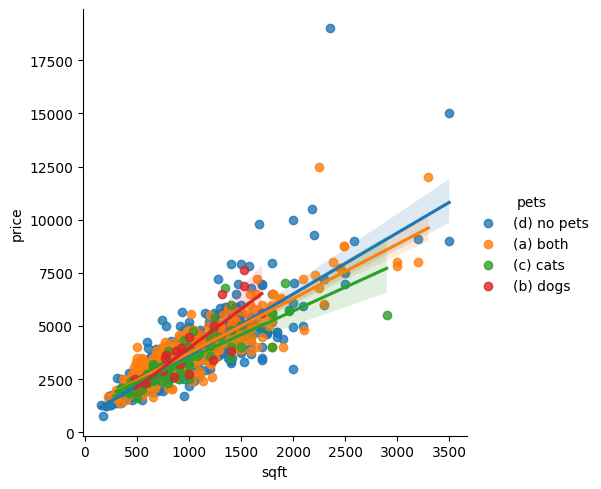

In [84]:
sns.lmplot(rentals_df, x="sqft", y="price", hue="pets")

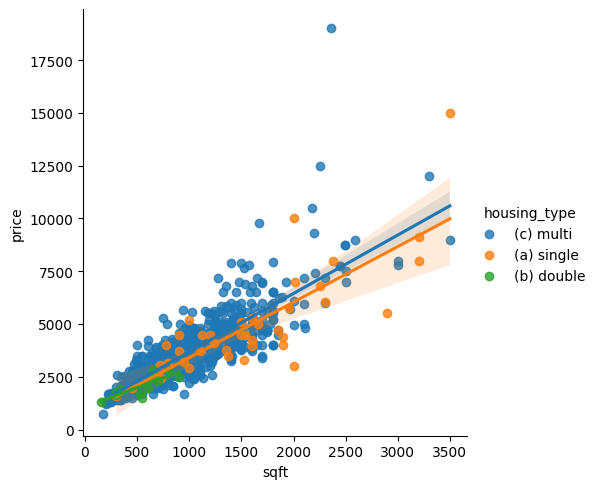

In [85]:
sns.lmplot(rentals_df, x="sqft", y="price", hue="housing_type")

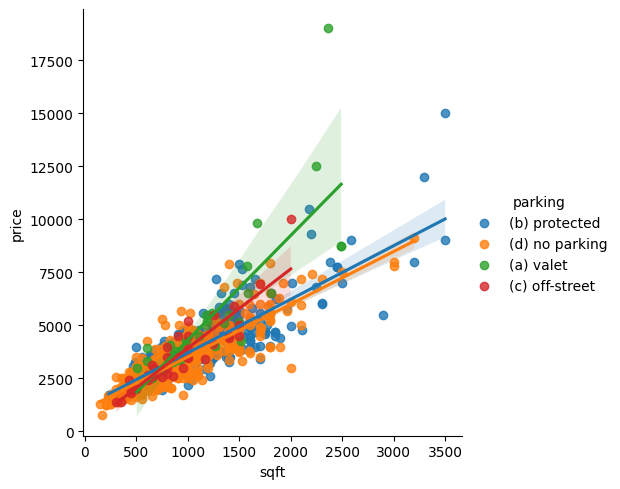

In [89]:
sns.lmplot(rentals_df, x="sqft", y="price", hue="parking")

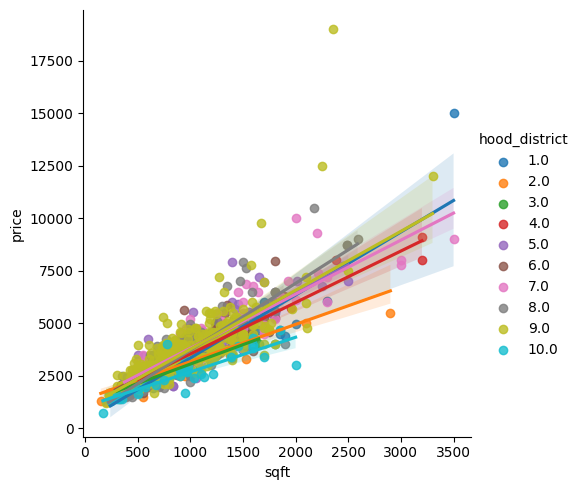

In [90]:
sns.lmplot(rentals_df, x="sqft", y="price", hue="hood_district")

In [91]:
!git add regression_modelling_project.ipynb
!git commit -m "regression_modelling_project-EDA"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


## Feature Engineering


In [42]:
pd.get_dummies(rentals_df).astype(int)

,price,sqft,beds,bath,hood_district,laundry_(a) in-unit,laundry_(b) on-site,laundry_(c) no laundry,pets_(a) both,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(a) single,housing_type_(b) double,housing_type_(c) multi,parking_(a) valet,parking_(b) protected,parking_(c) off-street,parking_(d) no parking
0,6800,1600,2,2,7,1,0,0,0,0,0,1,0,0,1,0,1,0,0
1,3500,550,1,1,7,1,0,0,1,0,0,0,0,0,1,0,1,0,0
2,5100,1300,2,1,7,1,0,0,1,0,0,0,0,0,1,0,0,0,1
3,9000,3500,3,2,7,1,0,0,0,0,0,1,0,0,1,0,1,0,0
4,3100,561,1,1,7,0,0,1,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,3595,1200,2,1,9,0,1,0,0,0,1,0,0,0,1,0,0,0,1
985,4695,1700,3,2,7,1,0,0,0,0,0,1,0,0,1,0,0,0,1
986,1950,450,1,1,3,0,0,1,0,0,0,1,1,0,0,0,0,1,0
987,3600,1100,3,1,8,1,0,0,0,0,0,1,0,0,1,0,0,0,1


## Data Splitting

## Model Fitting & Validation Scoring

## Assumptions Checking

## Final Model Fit & Test Scoring